# IMPORTS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

from transformers import BertTokenizer, TFBertModel, T5Tokenizer, TFT5ForConditionalGeneration

import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten

from datetime import datetime

from collections import defaultdict

import sentencepiece

# DATA PROCESSING

In [13]:
path = "./266 Photos/training"

In [14]:
def read_files(path):

    all_files = glob.glob(path + "/*.png")

    sentences = []
    images = []
    
    for filename in all_files:
        img = Image.open(filename)
        img = np.array(img) / 255.
        images.append(img)
        sentence = os.path.basename(os.path.normpath(os.path.splitext(filename)[0]))
        sentences.append(sentence)


    return sentences, images

In [15]:
english_sentences, images = read_files(path)

In [17]:
new_path = "./266 Photos/validation"
english_sentences.extend(read_files(new_path)[0])
images.extend(read_files(new_path[1]))

In [18]:
len(english_sentences)

64

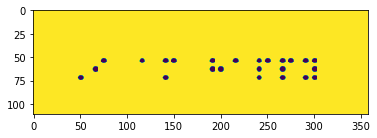

In [19]:
plt.imshow(images[0])

In [21]:
english_sentences[0]

'I am happy'

In [22]:
from pybraille import convertText

convertText("I am happy"), convertText("day")

('⠠⠊ ⠁⠍ ⠓⠁⠏⠏⠽', '⠙⠁⠽')

In [23]:
braille_sentences = []
for sentence in english_sentences:
    braille_sentences.append(convertText(sentence))

In [24]:
alphabet_english = []
alphabet_braille = []
alpha = 'a'
for i in range(0, 26): 
    alphabet_english.append(alpha)
    alphabet_braille.append(convertText(alpha))
    alpha = chr(ord(alpha) + 1)
for i in range(0, 10): 
    alphabet_english.append(i)
    alphabet_braille.append(convertText(str(i)))

In [25]:
convertText('1'), convertText('2'), convertText('12')

('⠼⠁', '⠼⠃', '⠼⠁⠃')

# Modeling ?

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [28]:
tokenizer.tokenize(english_sentences[0])

['I', 'am', 'happy']

In [33]:
tokenizer.encode(english_sentences[0])

[101, 146, 1821, 2816, 102]

In [30]:
braille_sentences[0].split()

['⠠⠊', '⠁⠍', '⠓⠁⠏⠏⠽']

In [35]:
tokenizer.encode(braille_sentences[0].split())

[101, 100, 100, 100, 102]

In [31]:
tokenizer.tokenize(braille_sentences[0])

['[UNK]', '[UNK]', '[UNK]']

In [36]:
bert = TFBertModel.from_pretrained('bert-base-cased')
bert.layers

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [38]:
# add sentences later

In [37]:
# Input: english sentence e, foreign sentence f, hash of translation probabilities t, epsilon 
# Output: probability of e given f

def probability_e_f(e, f, t, epsilon=1):
    l_e = len(e)
    l_f = len(f)
    p_e_f = 1
    
    for ew in e: # iterate over english words ew in english sentence e
        inner_sum = 0
        for fw in f: # iterate over foreign words fw in foreign sentence f
            inner_sum += t[(ew, fw)]
        p_e_f = inner_sum * p_e_f
    
    p_e_f = p_e_f * epsilon / (l_f**l_e)
    
    return p_e_f  

In [47]:
english_sentences[0].split()

['I', 'am', 'happy']

In [48]:
# Extract foreign and english vocabularies
foreign_words = []
english_words = []

for index in range(len(english_sentences)):
    for word in english_sentences[index].split(): 
        english_words.append(word)
    for word in braille_sentences[index].split(): 
        foreign_words.append(word)
        
english_words = sorted(list(set(english_words)), key=lambda s: s.lower()) 
foreign_words = sorted(list(set(foreign_words)), key=lambda s: s.lower())
print('English vocab: ', english_words)
print('Foreign vocab: ', foreign_words)

english_vocab_size = len(english_words)
foreign_vocab_size = len(foreign_words)
print('english_vocab_size: ', english_vocab_size)
print('foreign_vocab_size: ', foreign_vocab_size)

English vocab:  ['100', '12', '2', '22', '3', 'a', 'Alice', 'am', 'America', 'an', 'and', 'Angeles', 'Anna', 'apples', 'are', 'ask', 'asparagus', 'at', 'attend', 'awhile', 'baby', 'basement', 'be', 'bed', 'been', 'behind', 'Berkeley', 'best', 'big', 'brussel', 'California', 'can', 'child', 'chips', 'Christina', 'cities', 'Claus', 'clothes', 'color', 'coming', 'cooking', 'couch', 'cream', 'cute', 'day', 'designated', 'dinner', 'divided', 'do', 'does', 'dog', 'dogs', 'doing', 'door', 'drink', 'driver', 'eat', 'eating', 'Every', 'everyday', 'everywhere', 'favor', 'favorite', 'fish', 'for', 'Friday', 'friend', 'friends', 'from', 'fuzzy', 'games', 'getting', 'Go', 'go', 'goes', 'going', 'good', 'groups', 'had', 'happy', 'has', 'have', 'He', 'her', 'here', 'Hi', 'high', 'his', 'homework', 'hospital', 'house', 'hungry', 'I', 'ice', 'in', 'into', 'is', 'John', 'laundry', 'left', 'library', 'like', 'likes', 'list', 'lives', 'Look', 'Los', 'love', 'loves', 'make', 'mall', 'Mariam', 'Mary', 'muse

In [49]:
# Routine to uniformly initialize word translation probabilities in t hash

def init_prob(t, init_val, english_words, foreign_words):
    for fw in foreign_words:
        for ew in english_words:
            tup = (ew, fw) # tuple required because dict key cannot be list
            t[tup] = init_val

In [56]:
# Input: Collection of sentence pairs sentence_pairs, hash of translation probabilities t, epsilon
# Output: Perplexity of model

def perplexity(sentence_pairs, t, epsilon=1, debug_output=False):
    pp = 0
    
    for sp in sentence_pairs:
        prob = probability_e_f(sp[1], sp[0], t)
        if debug_output:
            print('english sentence:', sp[1], 'foreign sentence:', sp[0])
            print(prob)
            print()
        pp += math.log(prob, 2) # log base 2
        
    pp = 2.0**(-pp)
    return pp

In [63]:
sentence_pairs = [ 
    [ ['⠞⠓⠑', '⠠⠓⠁⠥⠎'], ['the', 'house'] ], 
    [ ['⠞⠓⠑', '⠃⠕⠕⠅'], ['the', 'book'] ], 
    [ ['⠁', '⠃⠕⠕⠅'], ['a', 'book'] ]
]


In [67]:
num_iterations = 5
perplex = []
debug_output = True
s_total = {}

# Initialize probabilities uniformly
t = {}
init_val = 1.0 / foreign_vocab_size
init_prob(t, init_val, english_words, foreign_words)
print(english_words)
print(foreign_words);

# if debug_output:
#     print('Hash initialized')
#     print('No. of foreign/english pairs: ', len(t))
#     print('Content: ', t)
#     print('**************')
#     print()

# # Loop while not converged
# for iter in range(num_iterations):
    
#     # Calculate perplexity
#     pp = perplexity(sentence_pairs, t, 1, True)
#     print(pp)
#     print('**************')
#     perplex.append(pp)

#     # Initialize
#     count = {}
#     total = {}

#     for fw in foreign_words:
#         total[fw] = 0.0
#         for ew in english_words:
#             count[(ew, fw)] = 0.0

#     for sp in sentence_pairs:

#         # Compute normalization
#         for ew in sp[1]:
#             s_total[ew] = 0.0
#             for fw in sp[0]:
#                 s_total[ew] += t[(ew, fw)]

#         # Collect counts
#         for ew in sp[1]:
#             for fw in sp[0]:
#                 count[(ew, fw)] += t[(ew, fw)] / s_total[ew]
#                 total[fw] += t[(ew, fw)] / s_total[ew]

#     # Estimate probabilities
#     for fw in foreign_words:
#         for ew in english_words:
#             t[(ew, fw)] = count[(ew, fw)] / total[fw]


['100', '12', '2', '22', '3', 'a', 'Alice', 'am', 'America', 'an', 'and', 'Angeles', 'Anna', 'apples', 'are', 'ask', 'asparagus', 'at', 'attend', 'awhile', 'baby', 'basement', 'be', 'bed', 'been', 'behind', 'Berkeley', 'best', 'big', 'brussel', 'California', 'can', 'child', 'chips', 'Christina', 'cities', 'Claus', 'clothes', 'color', 'coming', 'cooking', 'couch', 'cream', 'cute', 'day', 'designated', 'dinner', 'divided', 'do', 'does', 'dog', 'dogs', 'doing', 'door', 'drink', 'driver', 'eat', 'eating', 'Every', 'everyday', 'everywhere', 'favor', 'favorite', 'fish', 'for', 'Friday', 'friend', 'friends', 'from', 'fuzzy', 'games', 'getting', 'Go', 'go', 'goes', 'going', 'good', 'groups', 'had', 'happy', 'has', 'have', 'He', 'her', 'here', 'Hi', 'high', 'his', 'homework', 'hospital', 'house', 'hungry', 'I', 'ice', 'in', 'into', 'is', 'John', 'laundry', 'left', 'library', 'like', 'likes', 'list', 'lives', 'Look', 'Los', 'love', 'loves', 'make', 'mall', 'Mariam', 'Mary', 'museum', 'my', 'My',

# Scratch Work

In [27]:
# path = "./266 Photos/training"
# all_files = glob.glob(path + "/*.png")
# for filename in all_files:
#     os.mkdir(filename[:-4])
    
# path = "./266 Photos/validation"
# all_files = glob.glob(path + "/*.png")
# for filename in all_files:
#     os.mkdir(filename[:-4])


In [55]:
# datagen = ImageDataGenerator()

# train_generator = datagen.flow_from_directory('./266 Photos/training')

# val_generator = datagen.flow_from_directory('./266 Photos/validation')

In [54]:
# K.clear_session()

# model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
# reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
# early_stop = EarlyStopping(patience=15,verbose=1)

# entry = L.Input(shape=(28,28,3))
# x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
# x = L.MaxPooling2D((2,2))(x)
# x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
# x = L.MaxPooling2D((2,2))(x)
# x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
# x = L.GlobalMaxPooling2D()(x)
# x = L.Dense(256)(x)
# x = L.LeakyReLU()(x)
# x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
# x = L.LeakyReLU()(x)
# x = L.Dense(26,activation='softmax')(x)

# model = Model(entry,x)
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# history = model.fit(train_generator,validation_data=val_generator,epochs=10,
#                               callbacks=[model_ckpt,reduce_lr,early_stop],verbose=0)